In [52]:
from google.colab import drive
drive.mount("/content/gdrive", force_remount=True)

Mounted at /content/gdrive


In [2]:
!pip install pydub

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [3]:
!pip install torchmetrics

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 512.4/512.4 KB 10.9 MB/s eta 0:00:00


In [4]:
import os
import sys
import warnings
import subprocess
from subprocess import call
from functools import partial

import librosa

from tqdm import tqdm

import numpy as np

import torch
from torch import nn, Tensor
import torch.nn.functional as F
from torch.nn.functional import pad

from torch.utils.data import Dataset
from torch.utils.data import DataLoader

from torchmetrics.audio import SignalDistortionRatio as SDR

import matplotlib.pyplot as plt

import pydub 

In [ ]:
# path_folder_in = '/content/gdrive/MyDrive/musdb18/test'
# path_folder_out = '/content/gdrive/MyDrive/createdmusdb18/test'
# 
# 
# 
# files = os.listdir(path_folder_in)
# for file in tqdm(files, position=0, leave=True):
#   # tqdm.write(f"current song : {file}")
#   file_in = path_folder_in + '/' + file
#   for i in range(5):
#     filesp = file.split(".")
#     filesp[-1] = f"{i}.mp3"
#     filesp = ".".join(filesp)
#     file_out = f"{path_folder_out}/{filesp}"
#     # tqdm.write(f"processing {file_out}", end='\r')
#     call(('ffmpeg', '-y', '-i', file_in, '-map', f'0:{i}', '-vn', file_out),
#          stdout=subprocess.DEVNULL,
#          stderr=subprocess.STDOUT)

In [53]:
train_path = '/content/gdrive/MyDrive/createdmusdb18/train/data_numpy'
target_path = '/content/gdrive/MyDrive/createdmusdb18/train/data_numpy_split'
song_np_full = []
count = 0
for i, filename in enumerate(tqdm(os.listdir(train_path))):
    song_np = np.load(os.path.join(train_path, filename))
    song_np_full.append(song_np)
    if i%5==4:
        song_np_full = np.stack(song_np_full)
        index = 0
        while index+16384 <= song_np_full.shape[1]:
            np.save(os.path.join(target_path, str(count)), song_np_full[:, index:index+16384])
            index+=16384
            count+=1
        song_np_full = []

100%|██████████| 500/500 [13:11<00:00,  1.58s/it]


In [55]:
class MUSDBDataset(Dataset):
    def __init__(self, data_dir: str, train:bool=True):
        self.music_fulllist = []
        self.music_list = []
        self.sep_list = []
        self.data_size = 500 if train is True else 250
        self.train = train
        self.crop_size = 284672
        if train:
            self.data_dir = os.path.join(data_dir, 'data_numpy_split')
        else:
            self.data_dir = os.path.join(data_dir, 'data_numpy')
        # if not os.path.exists(self.data_dir) or \
        #     len([name for name in os.listdir(self.data_dir)]) < self.data_size:
        #     print("Data has not been saved as numpy object. Converting...")
        #     if not os.path.exists(self.data_dir):
        #         os.makedirs(self.data_dir)
        #     self.convert_to_numpy(data_dir, self.data_dir)
        self.music_fulllist = self.get_filenames(self.data_dir)
        if not train:
            self.music_list, self.sep_list = self.separate_source(self.music_fulllist)

    def __len__(self):
        return len(self.music_fulllist) if self.train else len(self.music_list)
        #return len(self.music_list)

    def __getitem__(self, idx):
        if self.train:
            music = self.music_fulllist[idx]
            music = np.load(music)
            return np.expand_dims(music[0], 0), music[1:]
        else:
            base_music = self.music_list[idx]
            base_music = np.load(base_music)
            base_music = np.stack([base_music[:self.crop_size]])

            sep_music = self.sep_list[idx*4 : idx*4+4]
            sep_music = np.stack([np.load(idx)[:self.crop_size] for idx in sep_music])
            return base_music, sep_music

    def get_filenames(self, path):
        files_list = list()
        for filename in os.listdir(path):
            files_list.append(os.path.join(path, filename))
        return files_list

    def convert_to_numpy(self, music_dir, target_dir):
        warnings.filterwarnings('ignore')
        music_list = self.get_filenames(music_dir)
        for music in tqdm(music_list):
            outfile_name = music.split("/")[-1]
            outfile_name = target_dir + "/" + outfile_name
            arr, _ = librosa.load(music)
            np.save(outfile_name, arr)

    def separate_source(self, mus_list):
        warnings.filterwarnings('ignore')
        music_list = list()
        sep_list = list()
        for music in tqdm(mus_list):
            mus_type = music.split(".")[-3]
            if mus_type == '0':
                music_list.append(music)
            else:
                sep_list.append(music)

        return music_list, sep_list

In [56]:
# train_ds = MUSDBDataset('/content/gdrive/MyDrive/createdmusdb18/train')
train_ds = MUSDBDataset('/content/gdrive/MyDrive/createdmusdb18/train')
test_ds = MUSDBDataset('/content/gdrive/MyDrive/createdmusdb18/test', train=False)

100%|██████████| 250/250 [00:00<00:00, 765943.02it/s]


In [57]:
train_ds[0][1].shape

(4, 16384)

In [58]:
test_ds[0][1].shape

(4, 284672)

In [59]:
train_dataloader = DataLoader(train_ds, batch_size=16)
test_dataloader = DataLoader(test_ds, batch_size=16)

In [60]:
class DownSampling(nn.Module):
    def __init__(self, in_ch=1, out_ch=24, kernel_size=15):
        super().__init__()
        self.net = nn.Sequential(
            nn.Conv1d(in_ch, out_ch, kernel_size=kernel_size, padding=7),
            nn.LeakyReLU(inplace=True),
            nn.Conv1d(out_ch, out_ch, kernel_size=kernel_size, padding=7),
            nn.LeakyReLU(inplace=True),
        )
        
    def forward(self, x: Tensor):
        x = self.net(x)
        return x

In [61]:
class UpSampling(nn.Module):
    def __init__(self, in_ch, out_ch, kernel_size):
        super().__init__()
        self.upsample = nn.Upsample(scale_factor=2, mode="linear", align_corners=True)
        self.conv = nn.Sequential(
            nn.Conv1d(in_ch, out_ch, kernel_size=kernel_size, padding=2),
            nn.LeakyReLU(inplace=True),
            nn.Conv1d(out_ch, out_ch, kernel_size=kernel_size, padding=2),
            nn.LeakyReLU(inplace=True),
        )
        
    def forward(self, x, x_back):
        x = self.upsample(x);
        diff = x_back.shape[-1] - x.shape[-1]
        x = pad(x, (0, diff))
        x = torch.cat([x, x_back], axis=1)
        return self.conv(x)

In [62]:
class WaveUNet(nn.Module):
    def __init__(self, n_level=12, n_source=4):
        super().__init__()
        self.level = n_level
        
        layers=[DownSampling(in_ch=1,out_ch=24,kernel_size=15)]
        
        for i in range(self.level-1):
            layers.append(DownSampling(in_ch=24*(i+1),out_ch=24*(i+2),kernel_size=15))
            
        # layers.append(DownSampling(in_ch=24*(self.level), out_ch=24*(self.level+1), kernel_size=15, decimate=False))
        layers.append(DownSampling(in_ch=24*(self.level), out_ch=24*(self.level+1), kernel_size=15))
            
        for i in range(self.level):
            layers.append(UpSampling(in_ch=24*(self.level+1-i) + 24*(self.level - i), out_ch=24*(self.level-i), kernel_size=5))
            
        self.net = nn.ModuleList(layers)
        self.separation = nn.Sequential(
            nn.Conv1d(25, n_source, kernel_size=1),
            nn.LeakyReLU(inplace=True),
            nn.Conv1d(n_source, n_source, kernel_size=1),
            nn.LeakyReLU(inplace=True),
        )
    
    def forward(self, x: Tensor):
        layer_to_concat = []
        # print("before in ", x.shape)
        layer_to_concat.append(x)
        for layer in self.net[0: self.level]:
            x = layer(x)
            # print("conv ", x.shape)
            layer_to_concat.append(x)
            x = x[:, :, 1::2]
            # print("decimate ", x.shape)
        x = self.net[self.level](x)
        # print("middle out ", x.shape)
        layer_to_concat.append(x)
        for i, layer in enumerate(self.net[self.level+1:]):
            # print("before up ", x.shape)
            x = layer_to_concat[-1]
            x = layer(x, layer_to_concat[-1-i-1])
            # print("after up ", x.shape)
            layer_to_concat[-1] = x
            
        x = torch.cat([layer_to_concat[0], x], axis=1)
        x = self.separation(x)

        return x

In [63]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device")

Using cuda device


In [64]:
model = WaveUNet(n_level=12).to(device)
# print(model)

In [65]:
loss_fn = nn.MSELoss()

test_loss = SDR().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001, betas=[0.9, 0.999])

In [66]:
def train(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    for batch, (X, y) in enumerate(dataloader):
        X, y = X.to(device), y.to(device)
        pred = model(X)
        loss = loss_fn(pred, y)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        if batch*len(X) % 800 == 0:
            print(f"loss : {loss.item()} ({batch*len(X)}/{size})")

        del pred
        del loss
        del X, y

In [67]:
def test(dataloader, model, loss_fn):
    model.eval()
    test_loss = 0
    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
    test_loss /= len(dataloader)
    print(f"Test loss : {test_loss}\n")

In [68]:
epochs = 30
for t in range(epochs):
    print(f"epoch : {t+1}\n---------------------------")
    model.train()
    train(train_dataloader, model, loss_fn, optimizer)
    test(test_dataloader, model, loss_fn)
    torch.cuda.empty_cache()

epoch : 1
---------------------------
loss : 0.03301911801099777 (0/30729)
loss : 0.017839204519987106 (800/30729)
loss : 0.0002462365082465112 (1600/30729)
loss : 0.0040946477092802525 (2400/30729)
loss : 0.002815782791003585 (3200/30729)
loss : 0.004637870471924543 (4000/30729)
loss : 0.0006262432434596121 (4800/30729)
loss : 0.0029275156557559967 (5600/30729)
loss : 0.0006390626076608896 (6400/30729)
loss : 0.005832795985043049 (7200/30729)
loss : 0.006514036096632481 (8000/30729)
loss : 0.0031051423866301775 (8800/30729)
loss : 0.0035126020666211843 (9600/30729)
loss : 0.002043253742158413 (10400/30729)
loss : 0.002908873837441206 (11200/30729)
loss : 0.003960856236517429 (12000/30729)
loss : 0.001287031453102827 (12800/30729)
loss : 0.0011831902666017413 (13600/30729)
loss : 0.0051181623712182045 (14400/30729)
loss : 0.004767945036292076 (15200/30729)
loss : 0.0015862714499235153 (16000/30729)
loss : 0.0002297628961969167 (16800/30729)
loss : 0.0004441766650415957 (17600/30729)
lo

KeyboardInterrupt: ignored

In [69]:
torch.save(model.state_dict(), "/content/gdrive/MyDrive/model2.pth")

In [70]:
model_load = WaveUNet().to(device)
model_load.load_state_dict(torch.load("/content/gdrive/MyDrive/model2.pth"))

<All keys matched successfully>

In [89]:
test_arr = torch.Tensor(test_ds[0][0]).to(device)

In [92]:
test_arr = torch.unsqueeze(test_arr, 0)

In [94]:
model_load.eval()
with torch.no_grad():
    pred = model_load(test_arr)

In [74]:
def write(f, sr, x, normalized=False):
    """numpy array to MP3"""
    channels = 2 if (x.ndim == 2 and x.shape[1] == 2) else 1
    if normalized:  # normalized array - each item should be a float in [-1, 1)
        y = np.int16(x * 2 ** 15)
    else:
        y = np.int16(x)
    song = pydub.AudioSegment(x.tobytes(), frame_rate=sr, sample_width=2, channels=1)
    song.export(f, format="mp3", bitrate="320k")

# write('/content/gdrive/MyDrive/test.mp3', 22050, np.array(splittest[0][0].cpu()), normalized=True)

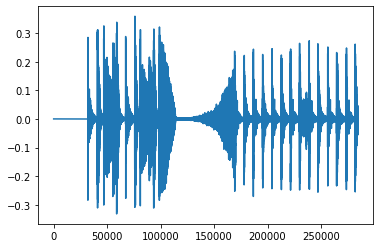

In [112]:
plt.plot(test_ds[0][1][0])

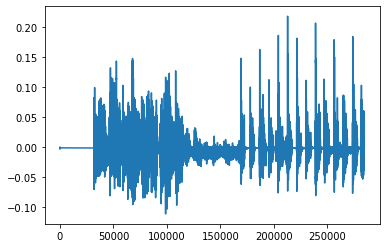

In [113]:
plt.plot(pred[0][0].cpu())

In [114]:
import soundfile

soundfile.write('/content/gdrive/MyDrive/model_out/test0.wav', 
                test_ds[0][1][0], 
                22050, 
                format='wav')

soundfile.write('/content/gdrive/MyDrive/model_out/test0_out.wav', 
                pred[0][0].cpu(), 
                22050, 
                format='wav')

In [102]:
write('/content/gdrive/MyDrive/test2.mp3', 22050, test_ds[0][1][1], normalized=True)

In [ ]:
pred[0]

tensor([[-3.1242e-03, -5.1037e-03, -6.8920e-03,  ..., -9.6870e-04,
         -8.3271e-04, -6.1841e-04],
        [-4.6458e-03, -9.0684e-03, -1.3509e-02,  ...,  1.0061e-01,
          8.9305e-02,  8.5974e-02],
        [-5.0559e-03, -1.2085e-02, -2.0577e-02,  ..., -5.6188e-04,
         -4.4316e-04, -6.3813e-05],
        [-2.3955e-03, -6.8933e-03, -1.3077e-02,  ..., -2.9201e-04,
         -3.5774e-04, -3.2391e-04]], device='cuda:0')